In [1]:
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(scater))
suppressPackageStartupMessages(library(emmeans))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(lmerTest))
suppressPackageStartupMessages(library(msigdbr))
suppressPackageStartupMessages(library(dplyr))

In [2]:
setwd('/lustre/scratch117/cellgen/team297/kt16/COVID_imperial_renal/')
sce <- readRDS('h5ad/df.fil3_gex_bcells_vdj_sce_B_naive.RDS')
counts(sce) <- assays(sce)[['X']] # because i'm saving from a h5ad object with anndata2ri
sce$case_control <- factor(sce$case_control, levels = c('NEGATIVE', 'POSITIVE', 'RECOVERY'))
sce$WHO_temp_severity <- factor(sce$WHO_temp_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'))
sce$WHO_temp_severity_group <- factor(sce$WHO_temp_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'), labels = c('NA', 'mild_moderate', 'mild_moderate', 'severe_critical', 'severe_critical'))
sce$WHO_severity_group <- factor(sce$WHO_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'), labels = c('NA', 'mild_moderate', 'mild_moderate', 'severe_critical', 'severe_critical')) # interpreted as peak severity
sce$grouped_temp_severity <- ifelse(sce$WHO_temp_severity %in% c("mild", "moderate"), "mild_moderate", "severe_critical")
sce$grouped_severity <- ifelse(sce$WHO_severity %in% c("mild", "moderate"), "mild_moderate", "severe_critical")
sce$age_scaled <- scale(sce$calc_age) # scale age
min_cells = 10
# remove samples >21 days
sce2 <- sce[,sce$time_from_infection <= 21] # prevent issues with spline
# Remove samples with less than 10 cells
nCells <- table(sce2$sample_id)
rmSamples <- names(nCells[nCells < min_cells])
sce2 <- sce2[, !sce2$sample_id %in% rmSamples]
# remove negatives and recoveries
sce3 <- sce2[,sce2$case_control == 'POSITIVE']
sce3

class: SingleCellExperiment 
dim: 32913 29106 
metadata(10): WHO_temp_severity_colors case_control_colors ...
  initial_cluster_B_colors seurat_clusters_colors
assays(2): X counts
rownames(32913): MIR1302-2HG FAM138A ... AC213203.1 FAM231C
rowData names(6): vst.mean vst.variance ... vst.variable GEX
colnames(29106): UK-CIC10689738+UK-CIC10690026_CCACTACGTGATAAGT-1
  UK-CIC10689738+UK-CIC10690026_CTGAAGTGTATTCTCT-1 ...
  UK-CIC10690384+UK-CIC10690576_TTTATGCGTCATCCCT-1
  UK-CIC10690384+UK-CIC10690576_TTTGGTTGTACGAAAT-1
colData names(72): orig.ident nCount_RNA ... grouped_severity
  age_scaled
reducedDimNames(5): X_harmony_rna X_pca_rna UMAP X_umapafterharmony_rna
  X_umapbeforeharmony_rna
altExpNames(0):

In [3]:
# Summarize Counts
smrzd <- aggregateAcrossCells(sce3, id = as.character(colData(sce3)[, c("sample_id")]))
smrzd <- logNormCounts(smrzd)
smrzd

class: SingleCellExperiment 
dim: 32913 127 
metadata(10): WHO_temp_severity_colors case_control_colors ...
  initial_cluster_B_colors seurat_clusters_colors
assays(2): counts logcounts
rownames(32913): MIR1302-2HG FAM138A ... AC213203.1 FAM231C
rowData names(6): vst.mean vst.variance ... vst.variable GEX
colnames(127): C101_130121 C101_180121 ... C93_2104 C93_2704
colData names(75): orig.ident nCount_RNA ... ncells sizeFactor
reducedDimNames(5): X_harmony_rna X_pca_rna UMAP X_umapafterharmony_rna
  X_umapbeforeharmony_rna
altExpNames(0):

In [4]:
length(table(droplevels(smrzd$individual_id)))

[1] 37

In [5]:
fullFormula = as.formula("geneset ~ splines::bs(time_from_infection, degree = 2) * grouped_severity + sex + ethnicity + age_scaled + centre + (1|individual_id)")
fullFormula

geneset ~ splines::bs(time_from_infection, degree = 2) * grouped_severity + 
    sex + ethnicity + age_scaled + centre + (1 | individual_id)

### Run the spline model but on gene sets

### Hallmark

In [6]:
m <- msigdbr(category = 'H')
genelists <- split(m, m$gs_name)
genelists <- lapply(genelists, function(x) x %>% select(gene_symbol) %>% unlist %>% as.character)

In [7]:
seu <- as.Seurat(smrzd)
data <- seu@meta.data
seu <- AddModuleScore(seu, features = genelists, name = names(genelists))

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_harmony_rna_ to Xharmonyrna_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to Xharmonyrna_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_pca_rna_ to Xpcarna_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to Xpcarna_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_umapafterharmony_rna_ to Xumapafterharmonyrna_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to Xumapafterharmonyrna_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_umapbeforeharmony_rna_ to Xumapbefor

In [8]:
fits <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
    data$geneset <- seu@meta.data[,x]
    fit <- lmerTest::lmer(fullFormula, data = data)
    return(list(fit=fit, data=data))
})

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



In [9]:
fit_res <- lapply(fits, function(x) anova(x$fit))
singular <- lapply(fits, function(x) as.numeric(isSingular(x$fit)))
conv <- lapply(fits, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
pvals <- lapply(fit_res, function(x) x[7,6])
qvals <- p.adjust(pvals, method = 'BH')
df = data.frame(pvals = unlist(pvals), 
                qvals = unlist(qvals), 
                singular = unlist(singular), 
                conv = unlist(conv), 
                row.names = paste0(names(genelists), 1:length(genelists)))
df = df[df$qval < 0.05 & df$singular == 0 & df$conv == 0,]
df

,pvals,qvals,singular,conv
,<dbl>,<dbl>,<dbl>,<int>
HALLMARK_INTERFERON_GAMMA_RESPONSE27,0.000712356,0.0356178,0,0


Warning message in grid.Call.graphics(C_polygon, x$x, x$y, index):
“semi-transparency is not supported on this device: reported only once per page”
Warning message in grid.Call.graphics(C_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”


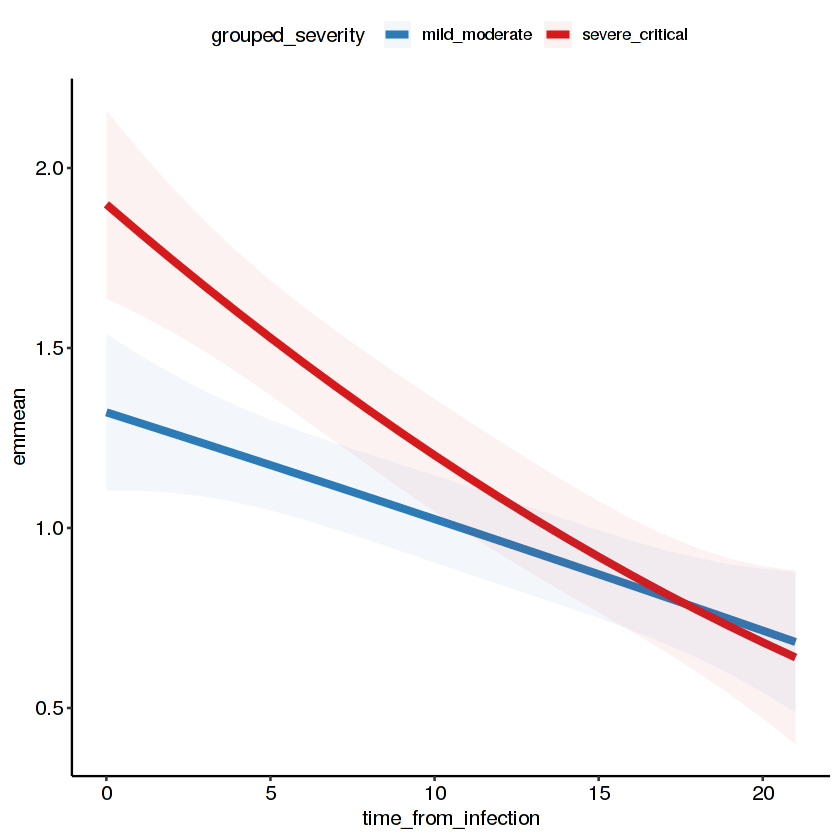

Warning message in grid.Call.graphics(C_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”


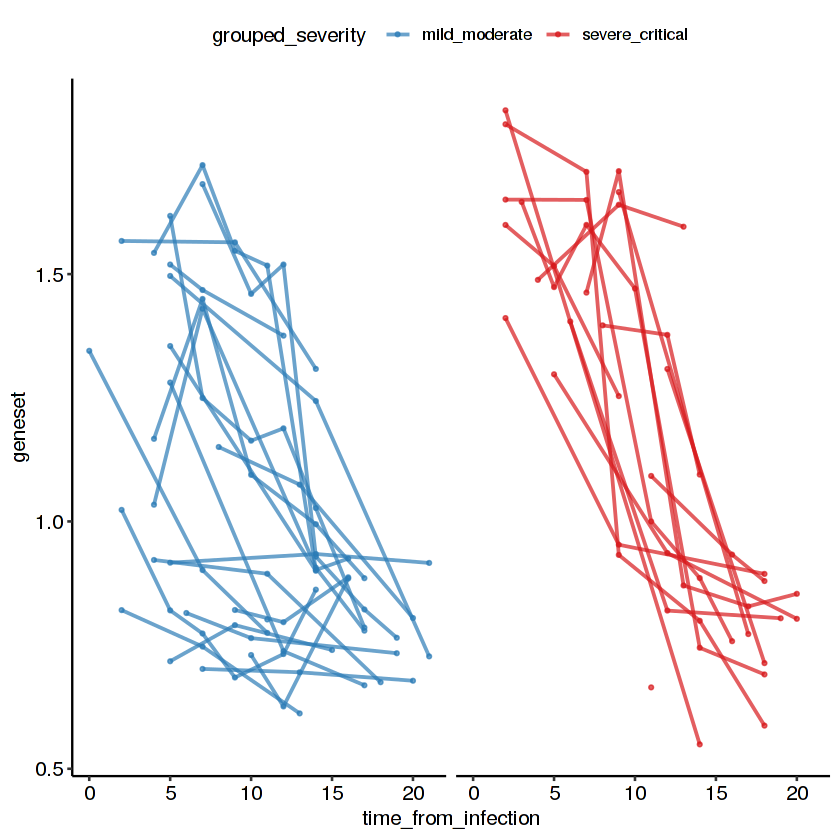

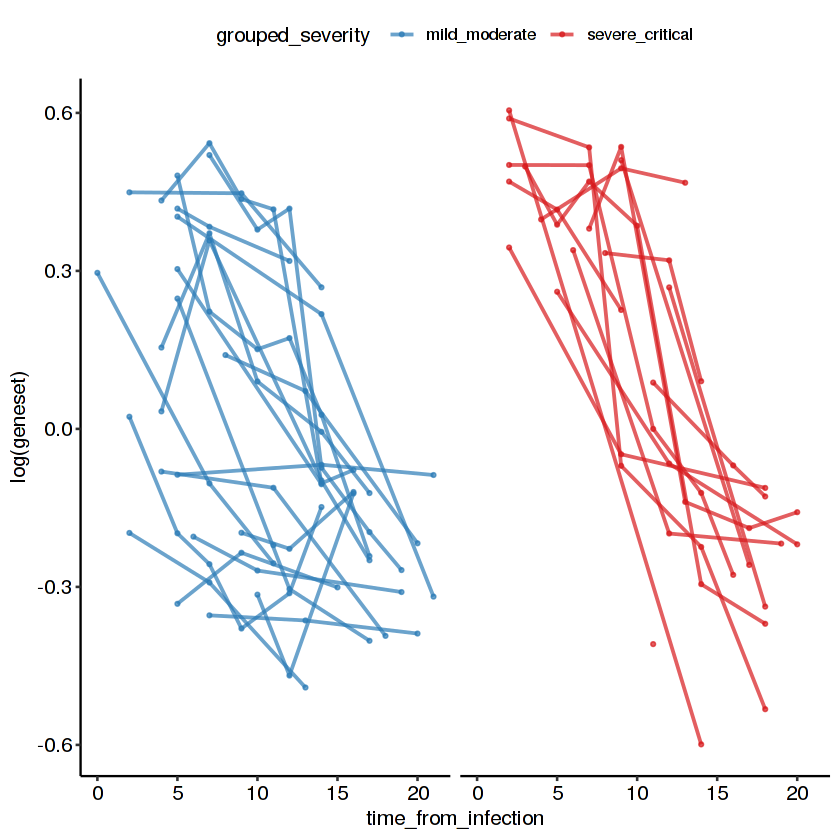

In [10]:
i = 27
x = emmeans(fits[[i]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

ggplot(data.frame(x), aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) +
    geom_line(aes(colour = grouped_severity), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))

ggplot(fits[[i]]$data, aes(time_from_infection, geneset, col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

ggplot(fits[[i]]$data, aes(time_from_infection, log(geneset), col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

### KEGG

In [11]:
m <- msigdbr(category = 'C2', subcategory = 'CP:KEGG')
genelists <- split(m, m$gs_name)
genelists <- lapply(genelists, function(x) x %>% select(gene_symbol) %>% unlist %>% as.character)

In [12]:
seu <- as.Seurat(smrzd)
data <- seu@meta.data
seu <- AddModuleScore(seu, features = genelists, name = names(genelists))

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_harmony_rna_ to Xharmonyrna_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to Xharmonyrna_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_pca_rna_ to Xpcarna_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to Xpcarna_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_umapafterharmony_rna_ to Xumapafterharmonyrna_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to Xumapafterharmonyrna_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_umapbeforeharmony_rna_ to Xumapbefor

Warning message:
“The following features are not present in the object: TAS2R45, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: SKP1P2, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: WARS1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: HLA-DRB3, HLA-DRB4, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: SKP1P2, UBE2NL, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: IARS1, LARS1, VARS1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: MMUT, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: IRAG1, not searching for symbol synonyms”
Warning message:
“The following features are not p

In [13]:
fits <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
    data$geneset <- seu@meta.data[,x]
    fit <- lmerTest::lmer(fullFormula, data = data)
    return(list(fit=fit, data=data))
})

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSi

In [14]:
fit_res <- lapply(fits, function(x) anova(x$fit))
singular <- lapply(fits, function(x) as.numeric(isSingular(x$fit)))
conv <- lapply(fits, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
pvals <- lapply(fit_res, function(x) x[7,6])
qvals <- p.adjust(pvals, method = 'BH')
df = data.frame(pvals = unlist(pvals), 
                qvals = unlist(qvals), 
                singular = unlist(singular), 
                conv = unlist(conv), 
                row.names = paste0(names(genelists), 1:length(genelists)))
df = df[df$qval < 0.05 & df$singular == 0 & df$conv == 0,]
df

pvals,qvals,singular,conv
<dbl>,<dbl>,<dbl>,<int>


In [16]:
# i = 13
# x = emmeans(fits[[i]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
# theme_set(theme_pubr())

# ggplot(data.frame(x), aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) +
#     geom_line(aes(colour = grouped_severity), size = 1.7) +
#     geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
#     scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
#     scale_fill_manual(values = c("#2C7BB6", "#D7191C"))

# ggplot(fits[[i]]$data, aes(time_from_infection, geneset, col = grouped_severity)) +
#     geom_point(alpha = 0.7, size = 0.7) +
#     geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
#     scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
#     facet_wrap(~grouped_severity) +
#     theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

# ggplot(fits[[i]]$data, aes(time_from_infection, log(geneset), col = grouped_severity)) +
#     geom_point(alpha = 0.7, size = 0.7) +
#     geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
#     scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
#     facet_wrap(~grouped_severity) +
#     theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

### REACTOME

In [15]:
m <- msigdbr(category = 'C2', subcategory = 'CP:REACTOME')
genelists <- split(m, m$gs_name)
genelists <- lapply(genelists, function(x) x %>% select(gene_symbol) %>% unlist %>% as.character)

In [16]:
seu <- as.Seurat(smrzd)
data <- seu@meta.data
seu <- AddModuleScore(seu, features = genelists, name = names(genelists))

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_harmony_rna_ to Xharmonyrna_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to Xharmonyrna_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_pca_rna_ to Xpcarna_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to Xpcarna_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_umapafterharmony_rna_ to Xumapafterharmonyrna_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to Xumapafterharmonyrna_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_umapbeforeharmony_rna_ to Xumapbefor

Warning message:
“The following features are not present in the object: IGHV1-2, IGHV1-46, IGHV1-69, IGHV2-5, IGHV2-70, IGHV3-11, IGHV3-13, IGHV3-23, IGHV3-30, IGHV3-33, IGHV3-48, IGHV3-53, IGHV3-7, IGHV4-34, IGHV4-39, IGHV4-59, IGKV1-12, IGKV1-16, IGKV1-17, IGKV1-33, IGKV1-39, IGKV1-5, IGKV1D-12, IGKV1D-16, IGKV1D-33, IGKV1D-39, IGKV2-28, IGKV2-30, IGKV2D-28, IGKV2D-30, IGKV2D-40, IGKV3-11, IGKV3-15, IGKV3-20, IGKV3D-20, IGKV4-1, IGKV5-2, IGLC2, IGLC3, IGLV1-40, IGLV1-44, IGLV1-47, IGLV1-51, IGLV2-11, IGLV2-14, IGLV2-23, IGLV2-8, IGLV3-1, IGLV3-19, IGLV3-21, IGLV3-25, IGLV3-27, IGLV6-57, IGLV7-43, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: AKR7L, BPNT2, GSTT1, GSTT2, MTARC1, MTARC2, PDCD6-AHRR, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: FCSK, GFUS, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: H2AB1

Warning message:
“The following features are not present in the object: H2AB1, H2AC14, H2AC18, H2AC19, H2AC20, H2AC4, H2AC6, H2AC7, H2AC8, H2AJ, H2AX, H2AZ1, H2AZ2, H2BC1, H2BC10, H2BC11, H2BC12, H2BC13, H2BC14, H2BC15, H2BC17, H2BC21, H2BC3, H2BC4, H2BC5, H2BC6, H2BC7, H2BC8, H2BC9, H2BS1, H2BU1, H3-3A, H3-3B, H3-4, H3C1, H3C10, H3C11, H3C12, H3C13, H3C14, H3C15, H3C2, H3C3, H3C4, H3C6, H3C7, H3C8, H4-16, H4C1, H4C11, H4C12, H4C13, H4C14, H4C15, H4C2, H4C3, H4C4, H4C5, H4C6, H4C8, H4C9, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: TUBB8B, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: TUBB8B, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: TUBB8B, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: HLA-DRB3, HLA-DRB4, TRAV19, TRAV29DV5, TRAV8-4, TRBV12-

Warning message:
“The following features are not present in the object: H2BC1, H2BC10, H2BC11, H2BC12, H2BC13, H2BC14, H2BC15, H2BC17, H2BC3, H2BC4, H2BC5, H2BC6, H2BC7, H2BC8, H2BC9, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: PDCD6-AHRR, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: H2AB1, H2AC14, H2AC18, H2AC19, H2AC20, H2AC4, H2AC6, H2AC7, H2AC8, H2AJ, H2AX, H2AZ1, H2AZ2, H2BC1, H2BC10, H2BC11, H2BC12, H2BC13, H2BC14, H2BC15, H2BC17, H2BC21, H2BC3, H2BC4, H2BC5, H2BC6, H2BC7, H2BC8, H2BC9, H2BS1, H2BU1, H3-3A, H3-3B, H3C1, H3C10, H3C11, H3C12, H3C13, H3C14, H3C15, H3C2, H3C3, H3C4, H3C6, H3C7, H3C8, H4-16, H4C1, H4C11, H4C12, H4C13, H4C14, H4C15, H4C2, H4C3, H4C4, H4C5, H4C6, H4C8, H4C9, POLR1F, POLR1G, POLR1H, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: H2AB1, H2AC14, H2AC18, H2AC19, H2AC20, H2AC4

Warning message:
“The following features are not present in the object: LORICRIN, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: H2AX, H2BC1, H2BC10, H2BC11, H2BC12, H2BC13, H2BC14, H2BC15, H2BC17, H2BC21, H2BC3, H2BC4, H2BC5, H2BC6, H2BC7, H2BC8, H2BC9, H2BS1, H2BU1, H3-4, H4-16, H4C1, H4C11, H4C12, H4C13, H4C14, H4C15, H4C2, H4C3, H4C4, H4C5, H4C6, H4C8, H4C9, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: H2AX, H2BC1, H2BC10, H2BC11, H2BC12, H2BC13, H2BC14, H2BC15, H2BC17, H2BC21, H2BC3, H2BC4, H2BC5, H2BC6, H2BC7, H2BC8, H2BC9, H2BS1, H2BU1, H3-4, H4-16, H4C1, H4C11, H4C12, H4C13, H4C14, H4C15, H4C2, H4C3, H4C4, H4C5, H4C6, H4C8, H4C9, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: ARSL, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: TUBB8B, not 

Warning message:
“The following features are not present in the object: NUP42, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: H2AB1, H2AC14, H2AC18, H2AC19, H2AC20, H2AC4, H2AC6, H2AC7, H2AC8, H2AJ, H2AX, H2AZ1, H2AZ2, H2BC1, H2BC10, H2BC11, H2BC12, H2BC13, H2BC14, H2BC15, H2BC17, H2BC21, H2BC3, H2BC4, H2BC5, H2BC6, H2BC7, H2BC8, H2BC9, H2BS1, H2BU1, H3-3A, H3-3B, H3-4, H4-16, H4C1, H4C11, H4C12, H4C13, H4C14, H4C15, H4C2, H4C3, H4C4, H4C5, H4C6, H4C8, H4C9, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: C4B_2, IGHV1-2, IGHV1-46, IGHV1-69, IGHV2-5, IGHV2-70, IGHV3-11, IGHV3-13, IGHV3-23, IGHV3-30, IGHV3-33, IGHV3-48, IGHV3-53, IGHV3-7, IGHV4-34, IGHV4-39, IGHV4-59, IGKV1-12, IGKV1-16, IGKV1-17, IGKV1-33, IGKV1-39, IGKV1-5, IGKV1D-12, IGKV1D-16, IGKV1D-33, IGKV1D-39, IGKV2-28, IGKV2-30, IGKV2D-28, IGKV2D-30, IGKV2D-40, IGKV3-11, IGKV3-15, IGKV3-20, IGKV3D-20, IGKV4-1, 

Warning message:
“The following features are not present in the object: MT-RNR1, MT-RNR2, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: GARS1, KARS1, QARS1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: CEP43, TUBB8B, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: TUBB8B, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: CEP43, TUBB8B, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: H2AB1, H2AC14, H2AC18, H2AC19, H2AC20, H2AC4, H2AC6, H2AC7, H2AC8, H2AJ, H2AX, H2AZ1, H2AZ2, H2BC1, H2BC10, H2BC11, H2BC12, H2BC13, H2BC14, H2BC15, H2BC17, H2BC21, H2BC3, H2BC4, H2BC5, H2BC6, H2BC7, H2BC8, H2BC9, H2BS1, H2BU1, H3-3A, H3-3B, H3-4, H3C1, H3C10, H3C11, H3C12, H3C13, H3C14, H3C15, H3C2, H3C3, H3C4, H3C

Warning message:
“The following features are not present in the object: H2AB1, H2AC14, H2AC18, H2AC19, H2AC20, H2AC4, H2AC6, H2AC7, H2AC8, H2AJ, H2AX, H2AZ1, H2AZ2, H2BC1, H2BC10, H2BC11, H2BC12, H2BC13, H2BC14, H2BC15, H2BC17, H2BC21, H2BC3, H2BC4, H2BC5, H2BC6, H2BC7, H2BC8, H2BC9, H2BS1, H2BU1, H3-3A, H3-3B, H3C1, H3C10, H3C11, H3C12, H3C13, H3C14, H3C15, H3C2, H3C3, H3C4, H3C6, H3C7, H3C8, H4-16, H4C1, H4C11, H4C12, H4C13, H4C14, H4C15, H4C2, H4C3, H4C4, H4C5, H4C6, H4C8, H4C9, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: H2AB1, H2AC14, H2AC18, H2AC19, H2AC20, H2AC4, H2AC6, H2AC7, H2AC8, H2AJ, H2AX, H2AZ1, H2AZ2, H2BC1, H2BC10, H2BC11, H2BC12, H2BC13, H2BC14, H2BC15, H2BC17, H2BC21, H2BC3, H2BC4, H2BC5, H2BC6, H2BC7, H2BC8, H2BC9, H2BS1, H2BU1, H3-3A, H3-3B, H3C1, H3C10, H3C11, H3C12, H3C13, H3C14, H3C15, H3C2, H3C3, H3C4, H3C6, H3C7, H3C8, H4-16, H4C1, H4C11, H4C12, H4C13, H4C14, H4C15, H4C2, H4C3, H4C4, H4C5, H4C6, H4C

Warning message:
“The following features are not present in the object: RNU11, RNU1-1, RNU12, RNU2-1, RNU4-1, RNU4ATAC, RNU5A-1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: CCN2, H2AB1, H2AC14, H2AC18, H2AC19, H2AC20, H2AC4, H2AC6, H2AC7, H2AC8, H2AJ, H2AX, H2AZ1, H2AZ2, H2BC1, H2BC10, H2BC11, H2BC12, H2BC13, H2BC14, H2BC15, H2BC17, H2BC21, H2BC3, H2BC4, H2BC5, H2BC6, H2BC7, H2BC8, H2BC9, H2BS1, H2BU1, H3-3A, H3-3B, H3C1, H3C10, H3C11, H3C12, H3C13, H3C14, H3C15, H3C2, H3C3, H3C4, H3C6, H3C7, H3C8, H4-16, H4C1, H4C11, H4C12, H4C13, H4C14, H4C15, H4C2, H4C3, H4C4, H4C5, H4C6, H4C8, H4C9, MIR132, MIR137, MIR24-1, MIR24-2, MIR27A, RNU11, RNU1-1, RNU12, RNU2-1, RNU4-1, RNU4ATAC, RNU5A-1, ZNF875, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: H2AB1, H2AC14, H2AC18, H2AC19, H2AC20, H2AC4, H2AC6, H2AC7, H2AC8, H2AJ, H2AX, H2AZ1, H2AZ2, H2BC1, H2BC10, H2BC11, H2BC12, H2BC1

Warning message:
“The following features are not present in the object: GARRE1, H2AB1, H2AC14, H2AC18, H2AC19, H2AC20, H2AC4, H2AC6, H2AC7, H2AC8, H2AJ, H2AX, H2AZ1, H2AZ2, H2BC1, H2BC10, H2BC11, H2BC12, H2BC13, H2BC14, H2BC15, H2BC17, H2BC21, H2BC3, H2BC4, H2BC5, H2BC6, H2BC7, H2BC8, H2BC9, H2BS1, H2BU1, H3-3A, H3-3B, H3C1, H3C10, H3C11, H3C12, H3C13, H3C14, H3C15, H3C2, H3C3, H3C4, H3C6, H3C7, H3C8, H4-16, H4C1, H4C11, H4C12, H4C13, H4C14, H4C15, H4C2, H4C3, H4C4, H4C5, H4C6, H4C8, H4C9, MRTFA, TUBB8B, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: IGHD, IGHV1-2, IGHV1-46, IGHV1-69, IGHV2-5, IGHV2-70, IGHV3-11, IGHV3-13, IGHV3-23, IGHV3-30, IGHV3-33, IGHV3-48, IGHV3-53, IGHV3-7, IGHV4-34, IGHV4-39, IGHV4-59, IGKV1-12, IGKV1-16, IGKV1-17, IGKV1-33, IGKV1-39, IGKV1-5, IGKV1D-12, IGKV1D-16, IGKV1D-33, IGKV1D-39, IGKV2-28, IGKV2-30, IGKV2D-28, IGKV2D-30, IGKV2D-40, IGKV3-11, IGKV3-15, IGKV3-20, IGKV3D-20, IGKV4-1, IGKV5-2, IGLC2

Warning message:
“The following features are not present in the object: AARS1, CARS1, DARS1, EPRS1, GARS1, HARS1, IARS1, KARS1, LARS1, MARS1, MT-RNR1, MT-RNR2, NARS1, QARS1, RARS1, SARS1, TARS1, VARS1, WARS1, YARS1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: TUBB8B, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: TUBB8B, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: TUBB8B, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: NUP42, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: NUP42, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: SLC66A1, not searching for symbol synonyms”
Warning message:
“The following features are not present in 

In [17]:
fits <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
    data$geneset <- seu@meta.data[,x]
    fit <- lmerTest::lmer(fullFormula, data = data)
    return(list(fit=fit, data=data))
})

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSi

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSi

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSi

In [18]:
fit_res <- lapply(fits, function(x) anova(x$fit))
singular <- lapply(fits, function(x) as.numeric(isSingular(x$fit)))
conv <- lapply(fits, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
pvals <- lapply(fit_res, function(x) x[7,6])
qvals <- p.adjust(pvals, method = 'BH')
df = data.frame(pvals = unlist(pvals), 
                qvals = unlist(qvals), 
                singular = unlist(singular), 
                conv = unlist(conv), 
                row.names = paste0(names(genelists), 1:length(genelists)))
df = df[df$qval < 0.05 & df$singular == 0 & df$conv == 0,]
df

pvals,qvals,singular,conv
<dbl>,<dbl>,<dbl>,<int>


In [ ]:
# i = 642
# x = emmeans(fits[[i]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
# theme_set(theme_pubr())

# ggplot(data.frame(x), aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) +
#     geom_line(aes(colour = grouped_severity), size = 1.7) +
#     geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
#     scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
#     scale_fill_manual(values = c("#2C7BB6", "#D7191C"))

# ggplot(fits[[i]]$data, aes(time_from_infection, geneset, col = grouped_severity)) +
#     geom_point(alpha = 0.7, size = 0.7) +
#     geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
#     scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
#     facet_wrap(~grouped_severity) +
#     theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

# ggplot(fits[[i]]$data, aes(time_from_infection, log(geneset), col = grouped_severity)) +
#     geom_point(alpha = 0.7, size = 0.7) +
#     geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
#     scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
#     facet_wrap(~grouped_severity) +
#     theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())